# Face Deep Dream Generation From Name Using Face to Name Classifying CNN

## Import Libraries

In [ ]:
import time
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.image import imread
import math
import os
import random
from tqdm import tqdm
from torch.autograd import Variable

Mount to google drive and unzip the folder containing the images in our dataset.

In [ ]:
from PIL import Image
from google.colab import drive

drive.mount('/content/gdrive')

!unzip gdrive/My\ Drive/Colab\ Notebooks/Names100_Images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Names100_Images/Thomas_64.png  
  inflating: Names100_Images/Thomas_640.png  
  inflating: Names100_Images/Thomas_641.png  
  inflating: Names100_Images/Thomas_642.png  
  inflating: Names100_Images/Thomas_643.png  
  inflating: Names100_Images/Thomas_644.png  
  inflating: Names100_Images/Thomas_645.png  
  inflating: Names100_Images/Thomas_646.png  
  inflating: Names100_Images/Thomas_647.png  
  inflating: Names100_Images/Thomas_648.png  
  inflating: Names100_Images/Thomas_649.png  
  inflating: Names100_Images/Thomas_65.png  
  inflating: Names100_Images/Thomas_650.png  
  inflating: Names100_Images/Thomas_651.png  
  inflating: Names100_Images/Thomas_652.png  
  inflating: Names100_Images/Thomas_653.png  
  inflating: Names100_Images/Thomas_654.png  
  inflating: Names100_Images/Thomas_655.png  
  inflating: Names100_Images/Thomas_656.png  
  inflating: Names100_Images/Thomas_657.png  
  inflating: Names100_Images/Th

Load in the text file containing the names and create labels for all of the images.

This creates a total of 80,000 labels 800 per name, with there being 100 names.

Also creates a mapping and reverse mapping from names to integer values.

In [ ]:
#Load the names text file
namesFile = "names100.txt"
f = open(namesFile, "r")

namesList = f.readlines()
namesList = [i[:-1] for i in namesList]
namesList.sort()

#Create the labels array
labels = []
for name in namesList:
  for _ in range (800):
    labels.append(name)

labels = np.array(labels)
print("Labels Array:")
print(labels)
print("\nNumber of labels: " + str(len(labels)))
set_of_labels = set(namesList)
mapping = dict()
reverse_mapping = dict()
#Create a map and reverse map from name to integer value representing a name
for index, name in enumerate(set_of_labels):
  mapping[index] = name
  reverse_mapping[name] = index

Labels Array:
['Aaron' 'Aaron' 'Aaron' ... 'Zoe' 'Zoe' 'Zoe']

Number of labels: 80000


## Loading Our Data

In [ ]:
def load_dataSet(labels, batch_size=32, train=True):

    dataset = []
    batch_counter = 0
    batch = []
    label_batch = []
    counter = 0
    # list(([array of 32 images], [array of 32 labels]),()....)
    for i, file in enumerate(tqdm(os.listdir('./Names100_Images'))):
        
        img = Image.open('./Names100_Images/' + file).resize((120, 150))
        img = np.asarray(img).reshape(3, 120, 150)
        label = labels[i]
        label = reverse_mapping[label]
        label = torch.tensor(label)

        if batch_counter < batch_size:
            batch.append(img)
            label_batch.append(label)
            batch_counter += 1
        else:
            dataset.append((np.array(batch), np.array(label_batch)))
            batch = []
            label_batch = []
            batch_counter = 0
        counter += 1
    
    random.shuffle(dataset)
    return dataset

In [ ]:
dataset = load_dataSet(labels, batch_size=32, train=True)

100%|██████████| 80000/80000 [01:54<00:00, 698.16it/s]


## Displaying Images and Labels From Our Dataset

In [ ]:
def plot_image(image):
    
    '''
    Takes in an image and shows it using matplotlib 
    this is used to visualize the data and also the outputs of our network
    '''

    image = image.reshape(-1, 150,120,3)

    plt.imshow(image[0])
    return

In [ ]:
def plot_image_and_label(image, label):
  image = image.reshape(-1, 150,120,3)
  plt.imshow(image[0])
  # print(type(label))
  if(isinstance(label, str)):
    plt.title("Label = " + label)
  else:
    label = label.detach()
    _, predicted = torch.max(label,-1)
    predicted_name = mapping[predicted.item()]
    plt.title("Best label = " + predicted_name + ", with Score: " + str(round(label[predicted].item() * 100,2)))
    plt.show()
  return

Show an image from the dataset along with its label:

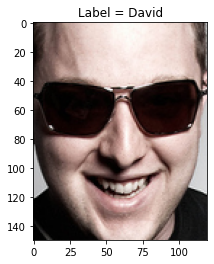

In [ ]:
ranNum = random.randint(0,1000)
data_point = dataset[ranNum]
ex_image = data_point[0]
ex_label = mapping[data_point[1][0].item()]
plot_image_and_label(ex_image,ex_label)

## Defining CNN To Clasify Faces To Names

In [ ]:
class MyCNN(nn.Module):

    def __init__(self, input_size, output_size):
        super(MyCNN, self).__init__()

        self.input_size = input_size # making the input size accessible
        in_channels = self.input_size[0]
        height = self.input_size[1]
        width = self.input_size[2]
        # TODO initalize your layers here 
         #################################
        self.cnn1 = nn.Conv2d(in_channels=in_channels, out_channels = 4, kernel_size=18, stride=1)
        self.cnn2 = nn.Conv2d(in_channels=4, out_channels = 5, kernel_size=12, stride=1)
        self.cnn3 = nn.Conv2d(in_channels=5, out_channels = 6, kernel_size=6, stride=1)
        self.cnn4 = nn.Conv2d(in_channels=6, out_channels = 8, kernel_size=3, stride=1)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.lin1 = nn.Linear(4480,2000)
        self.lin2 = nn.Linear(2000,100)
        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()    
                                          
        #################################


    def forward(self, x):
        x = x.view(-1, 3, 150, 120).float()   # This reshapes the input to work with the batches

        # TODO perform the forward pass of you model 
        # use the modules you initialized above (each should be used)
        # You should also include the self.relu between each layer (including conv2d ones)
        #################################
        out = self.relu(self.cnn1(x))
        out = self.relu(self.cnn2(out))
        out = self.pool1(self.relu(self.cnn3(out)))
        out = self.pool1(self.relu(self.cnn4(out)))
        out = self.flatten(out)
        out = self.relu(self.lin1(out))
        out = self.lin2(out)

        ################################

        return out

The following CNN consists of:
- 4 Convolutional layers

- 2 Max pooling layers which are applied after each of the last 2 convolutional layers

- 2 Linear Layers

Now let us take a look at how our model classifies an image before training:

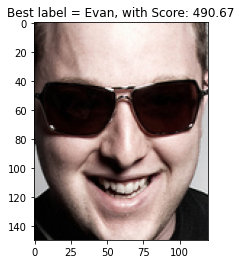

In [ ]:
test_model = MyCNN((3, 150, 120), 100)
ex_image = torch.tensor(ex_image)
test_output = test_model(ex_image)
label = test_output[0]
plot_image_and_label(ex_image[0].reshape(3, 150,120), label)

## Training And Testing The Model

Throughout training and testing our model we learned that classifying faces to names is an almost impossible task due to the fact that no two people with the same name really look the same. As a result even with a hyperparameter search, the best we could really get our model to do was guess. There are a couple factors that could also attribute to these results besides the difficulty of the task. One being the dataset itself, looking through the dataset it seems as if the pictures are scrapped from online and then cropped which sometimes results in some weird pictures being in the dataset. The other being the complexity of the model itself, if a larger model was used, even a pretrained one it is possible that the model could have done slightly better than guessing.

Connecting to a GPU

Training on the GPU reduced training time of 1 epoch from ~45 minutes to ~2 minutes.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
# training function here

def training(model, loss_function, optimizer, data, labels, n_epochs, update_interval):

    '''
    Updates the parameters of the given model using the optimizer of choice to
    reduce the given loss_function

    This will iterate over the dataloader 'n_epochs' times training on each batch of images
    
    To get the gradient (which is stored internally in the model) use .backward() from the loss tensor
    and to apply it use .step() on the optimizer

    In between steps you need to zero the gradient so it can be recalculated -- use .zero_grad for this
    '''
    
    losses = []
    model.to(device)
    print(len(labels),len(data))
    for n in range(n_epochs):
        for i, (image, label) in enumerate(tqdm(data)):

            # TODO Complete the training loop using the instructions above
            # Hint: the above code essentially does one training step
            
            ##############################################################
            optimizer.zero_grad()
            image = torch.tensor(image)
            label = torch.tensor(label)
            # print(image)
            image = image.to(device)
            label = label.to(device)
            my_output = model(image)
            loss = loss_function(my_output,label)
            loss.backward()
            optimizer.step()

            ##############################################################
        
            if i % update_interval == 0:
                losses.append(round(loss.item(), 2)) # This will append your losses for plotting -- please use "loss" as the name for your loss
        
    return model, losses

In [ ]:
def testing(model, loss_function, test_data):

    '''
    This function will test the given model on the given test_data
    it will return the accuracy and the test loss (given by loss_function) 
    '''
    
    sum_loss = 0
    n_correct = 0
    total = 0
    model.to(device)

    for i, (image, label) in enumerate(tqdm(iter(test_data))):

        # This is essentially exactly the same as the training loop 
        # without the, well, training, part
        image = torch.tensor(image)
        label = torch.tensor(label)
        image = image.to(device)
        label = label.to(device)
        pred = model(image).to('cpu')
        label = label.to('cpu')
        loss = loss_function(pred, label)
        sum_loss += loss.item()
        _, predicted = torch.max(pred,-1)
        n_correct += (torch.eq(predicted,label).sum())
        total += label.size(0)
    
    test_acc = ((n_correct / total).item() * 100)
    avg_loss = round(sum_loss / len(test_data), 2)

    print("test accuracy:", test_acc)
    print("test loss:", avg_loss )

    return test_acc, avg_loss

In [ ]:
def train_and_test(model, loss_function, optimizer, batch_size, update_interval, n_epochs,labels,dataset):

    '''
    This will use your/my methods to create a dataloader, train a gven model, and then test its performance

    Again, since I gave this to you for free you have to promise to look at it and try to understand it
    '''
    dataSetSplit = len(dataset)
    divisionFactor = math.floor(dataSetSplit / 5)
    testingSize = divisionFactor * 4

    data_train = dataset[:testingSize]
    data_test = dataset[testingSize:]


    trained_model, losses = training(model, loss_function, optimizer, data=data_train, labels=labels, n_epochs=n_epochs, update_interval=update_interval)

    test_acc, test_loss = testing(trained_model, loss_function, data_test)

    plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses, color="b", label="train loss")
    plt.hlines(test_loss, 0, len(losses) * batch_size * update_interval, color='r', label="test loss")
    plt.legend()
    plt.title("training curve")
    plt.xlabel("number of images trained on")
    plt.ylabel("loss")
    plt.show()
    #print(losses)

    return trained_model, test_loss

    

80000 1936


100%|██████████| 1936/1936 [01:01<00:00, 31.50it/s]
488it [00:04, 118.04it/s]


test accuracy: 0.877305306494236
test loss: 4.61


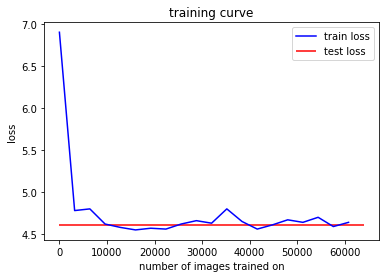

In [ ]:
lr = 1e-4              # The size of the step taken when doing gradient descent
batch_size = 32        # The number of images being trained on at once
update_interval = 100   # The number of batches trained on before recording loss
n_epochs = 1            # The number of times we train through the entire dataset
model = MyCNN((3, 150, 120), 100)                                          # Your Model for the CNN
loss_function = nn.CrossEntropyLoss()                           # This is a standard loss function for situations like this -- check it out on the API!
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
trained_model, _ = train_and_test(model, loss_function, optimizer, batch_size=batch_size, update_interval=update_interval, n_epochs=n_epochs,labels = labels,dataset=dataset)

# Hyperparameter Search Graphs
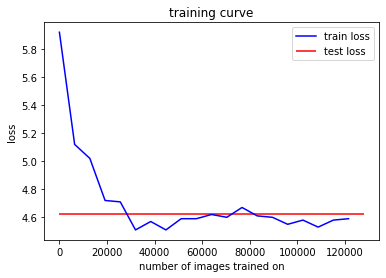
```
Final Accuracy: 0.34298
```
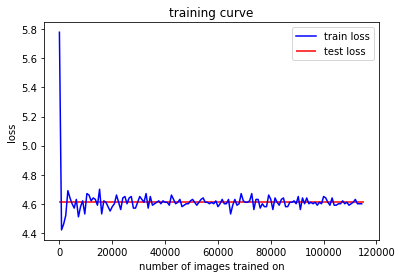
```
Final Accuracy: 0.4213
```
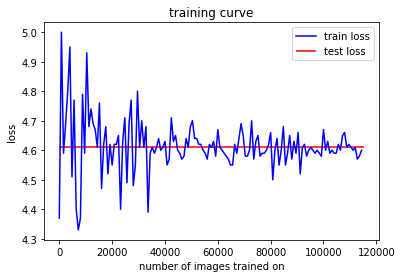

```
Final Accuracy: 0.71068
```

## Optimizing an Input Image to Look Like a Name

The process for doing this is as follows:

1.   Create an input image that will be manipulated with each iteration. We create this image by just generating random noise.
2.   Require a gradient on our input image, but not on our model.
3. Create an optimizer that will optimize over our image rather than the model's parameters.
4. Choose the name that we want to optimize for this example we will be optimizing our input to look like "Jeff".
5. Based on the name to label mapping create an "ideal label" which in this case would correspond to a 1 in the position where the label Jeff is and a 0 for all other names.
6. For each iteration we can then send our input image into our model to be classified. Take the classification labels and our ideal labels and put them into a loss function. Step our optimizer to update our input image.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 20000/20000 [00:56<00:00, 352.95it/s]


Original Input Image:


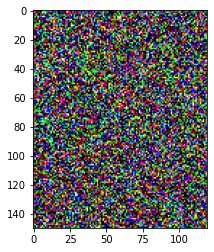

In [ ]:
image = torch.randn(1, 3, 150, 120)
#print(image.shape)
#print(image)
image = image.to(device)
npArr = image.to('cpu').detach().numpy()
# print original image
plot_image(npArr)
image.requires_grad = True
model.requires_grad = False
optimizer = torch.optim.Adam([image], lr=0.005)
loss_function_dreaming = nn.CrossEntropyLoss()
#Choose the name that you want to generate
idealName = "Evan"
#Convert the ideal name to its cooresponding integer mapping
idealNameIndex = reverse_mapping[idealName]
actual_label = torch.zeros(model(image).size()).to(device)
actual_label[:,idealNameIndex] = 1
dreaming_losses = np.array([])
target_probabilities = np.array([])
iterations_run = np.array([])
for iteration in tqdm(range(20000)):
    out = model(image)
    loss = loss_function_dreaming(out, actual_label)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iteration % 100 == 0:
        dreaming_losses = np.append(dreaming_losses, loss.to('cpu').detach().numpy())
        iterations_run = np.append(iterations_run, iteration)
        target_probability = torch.softmax(out, dim=1)[0, idealNameIndex]
        target_probabilities = np.append(target_probabilities, target_probability.to('cpu').detach().numpy())
print("Original Input Image:")

Now let us take a look at some graphs that resulted from this training.

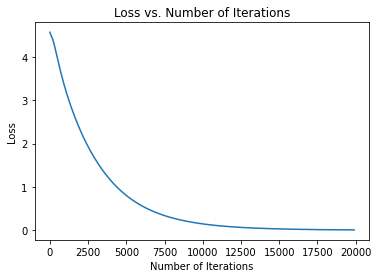

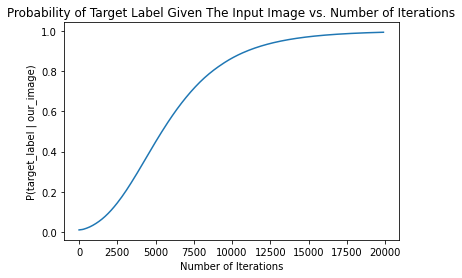

Final target probability: 99.31464791297913%


In [ ]:
plt.plot(iterations_run, dreaming_losses)
plt.title("Loss vs. Number of Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

plt.plot(iterations_run, target_probabilities)
plt.title("Probability of Target Label Given The Input Image vs. Number of Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("P(target_label | our_image)")
plt.show()

print(f"Final target probability: {target_probabilities[-1]*100}%")

Now let us take a look at what our "ideal Jeff" will look like:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


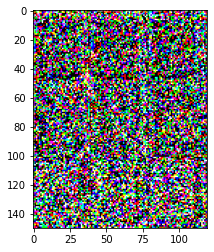

In [ ]:
npArr = image.to('cpu').detach().numpy()
plot_image(npArr)

GAN flashbacks huh?